In [ ]:
!pip install datasets==1.17.0 transformers[sentencepiece]==4.15.0
!pip install accelerate==0.5.1

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

In [ ]:
raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

# อะไรคือการตัดคำ?
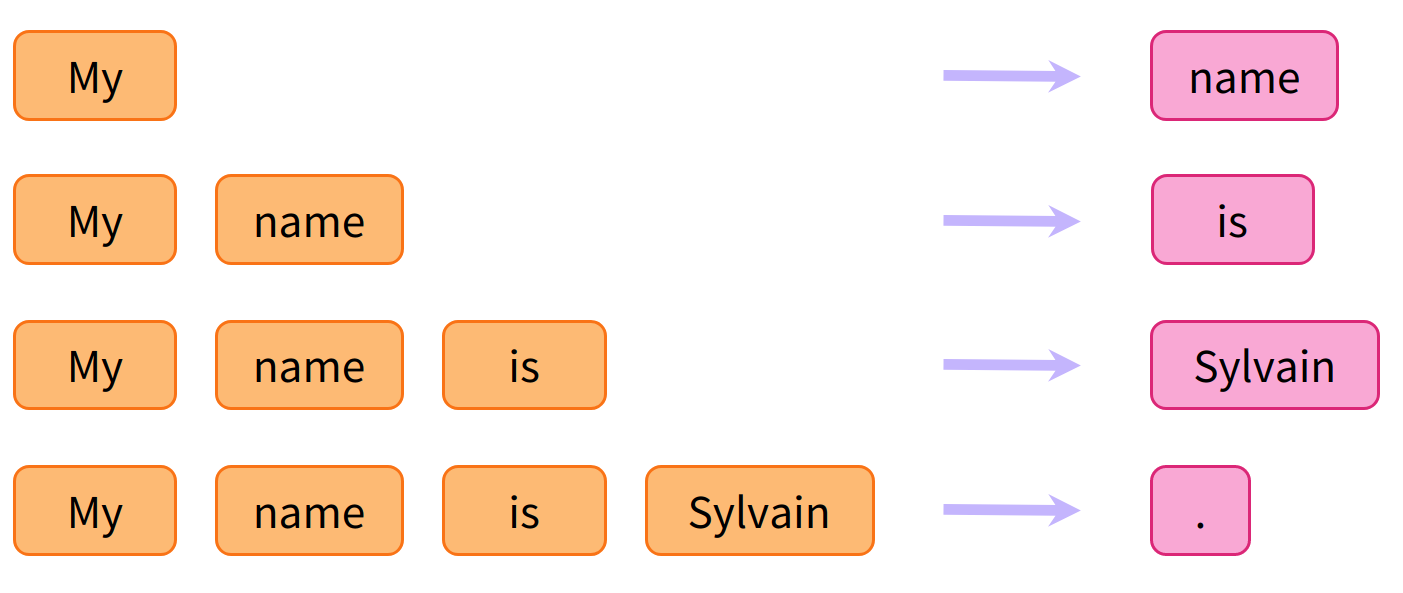

จากตัวอย่าง: จะเห็นได้ว่าโมเดลของเรารับ input เป็นคำๆเพราะ (i) มีความตัวอักษรที่ยังพอดี หากเป็นประโยคก็จะยาวไป หากเป็นตัวอักษร โมเดลก็จะเรียนรู้ได้ไม่ดีพอ (ii) การตัดคำไม่ได้ยากขนาดนั้น และการรับทั้งประโยคเป็น input ยังต้องการทรัพยากรมาก 

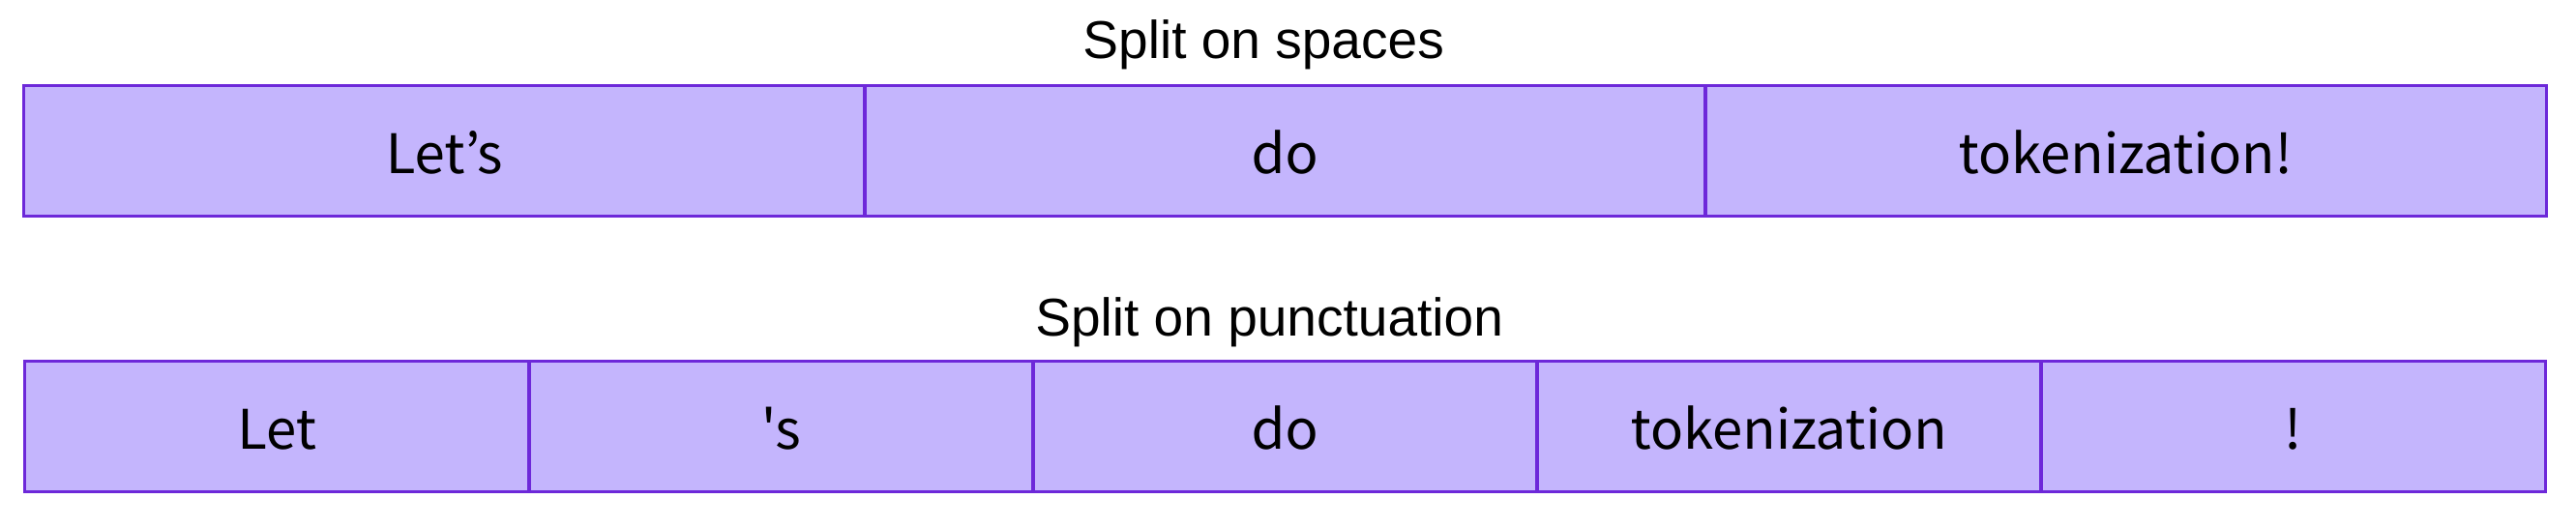

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer("Using a Transformer network is simple")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

# กำหนด Training Arguments
= ทาง Hugging Face มีค่า Default มาให้เราอยู่แล้ว ซึ่งสามารถปรับแต่งได้เยอะมาก!! 

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=test-trainer/runs/Jan1

# สร้างโมเดลเพื่อ Finetune !
## AutoModelForSequeceClassification
เป็นฟังก์ชั่นที่นำเอาโมเดลที่เราสนใจจะเอามาเทรน มาต่อกับ Linear Layer (เป็น layer สุดท้าย) โดยจะเรียกว่า "หัว Classifier" (Classifier Head) โดยเราจะใช้หัวนี้ในการทำนายประโยคนั้นเอง

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model, # โมเดลที่ผ่านการเพิ่ม classifier head
    training_args, # parameter จาก hugging face
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator, # ตัวสร้าง padding
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Step,Training Loss
500,0.633600
1000,0.639000


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1377, training_loss=0.6353745692522524, metrics={'train_runtime': 207.4708, 'train_samples_per_second': 53.039, 'train_steps_per_second': 6.637, 'total_flos': 419530577771520.0, 'train_loss': 0.6353745692522524, 'epoch': 3.0})

# ลองให้ทำนายของบน Validation Set

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


(408, 2) (408,)


In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)
print(predictions.predictions[:5],preds[:5]) 

[[0.07530639 1.0515649 ]
 [0.07476187 1.0519353 ]
 [0.07501341 1.0517609 ]
 [0.07496985 1.0517876 ]
 [0.07474935 1.0519395 ]] [1 1 1 1 1]


# วัดความแม่นยำบน Dev set

In [ ]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

{'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}

# แล้วจะรู้ได้ไงว่าโมเดลเราดีแล้ว?
= ก็วัด dev set ตอนเทรนเลยสิ!!

In [ ]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": 

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.624753,0.683824,0.812227
2,0.646700,0.694488,0.683824,0.812227
3,0.620800,0.606234,0.710784,0.820669


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoin

TrainOutput(global_step=1377, training_loss=0.6201452893802197, metrics={'train_runtime': 214.9056, 'train_samples_per_second': 51.204, 'train_steps_per_second': 6.407, 'total_flos': 419530577771520.0, 'train_loss': 0.6201452893802197, 'epoch': 3.0})

# แล้วถ้าถนัดเขียน Pytorch แบบปกติ? (hand-craft loop)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['attention_mask', 'input_ids', 'labels', 'token_type_ids']

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()} # ตรงนี้ต้องให้มั่นใจว่าออกมาแบบนี้!!

{'attention_mask': torch.Size([8, 70]),
 'input_ids': torch.Size([8, 70]),
 'labels': torch.Size([8]),
 'token_type_ids': torch.Size([8, 70])}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) #สร้างโมเดลเหมือนเดิม

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape) # ทดสอบก่อนว่า training data ของเรามันถูกไหม ถ้าถูกมันควรจะมี loss ออกมา

tensor(0.6813, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # ตรงนี้สำหรับคนใช้ GPU/CPU ในการเทรน
model.to(device)
device

device(type='cuda')

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1377 [00:00<?, ?it/s]

In [ ]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.7647058823529411, 'f1': 0.8344827586206897}